# YELP Reviews - Exploratory Data Analysis

In [8]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Data Import

In [9]:
df = pd.read_json(os.path.join('..', 'data', 'yelp_reviews.json.gz'), 
                  compression='gzip', lines=True)

# Data shape
df.shape

(125000, 9)

In [10]:
# Print a data sample
df.sample(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
96662,hv0cb5fwwlcPpQIuKOhLlQ,il8Wxn-Wc7o1vnZEn8B3UQ,WXR0ND0KqbArMZDvFMA-bw,3,0,0,0,I'm quite confused by their concept. I was mee...,2017-07-01 01:30:43
122603,Td_WCHxzFCv9obTxdfXYgA,bYgBglTb3Q76BwxGTDGIQw,jppxrDQLXr4Nk8cV7IGlcw,2,1,0,0,My husband and I stopped in here about 4:00 on...,2016-08-29 01:35:06
35203,n3-SO_MZpY1U1oR-adNkuQ,AqComMZRWFRvAVM368LYEw,HRLHrJudlNsmtY-je3PDLQ,5,0,0,1,Excellent 90 minute massage! I was slightly e...,2011-09-27 06:25:37
84458,qsh895RBzz39rJhXAS4sww,yi_4YTVS6XL7s5atKPbmpA,4LXZzgsrM1ZyS_-uB9Od2Q,3,1,0,0,Pretty good pizza....better than the usual cha...,2009-11-07 15:49:50
32906,u1q_-tOuEHOt4P8unZ9qDg,_ruc02r0XAMCueMp1RH0hw,0xAgZvViupzyq85Qj-s2jA,1,7,0,0,At new location - went in just for a cut. I ha...,2013-08-16 03:20:39


We'll only use `text` as our predictive variable, while `stars` will be the target variable. Next, we'll take a closer look at them. The other features will be discarded.

## Stars Distribution

In `data_utils.py` we generated the dataset in such a way that every star rating category contains 25,000 reviews. Here, we will just double check that data extraction was successfull and ratings distribution looks exactly as we expect. The same (large) number of reviews per star rating category ensures that the model sees diverse examples per each category and, at the same time, will not overfit.

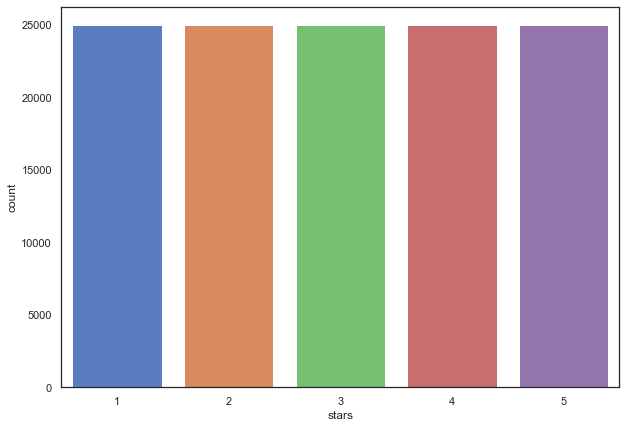

In [11]:
sns.set(style="white", palette="muted", color_codes=True) 

plt.figure(figsize=(10,7))
sns.countplot(df['stars'])
plt.show()

That's exactly what we expected :)

## Most Popular Words per Star Rating

We'll create word clouds for visualisation and won't bother about actual numbers so far. The word clouds will give us a general impression about words distribution per star rating.

Rating: 1 stars


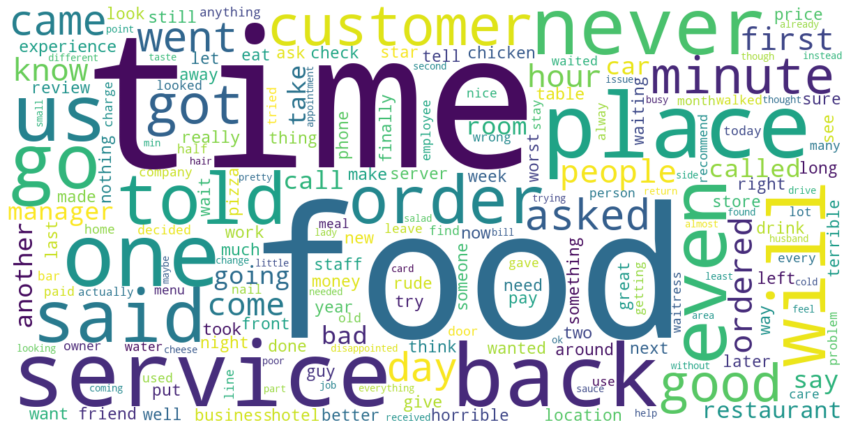

*************************
Rating: 2 stars


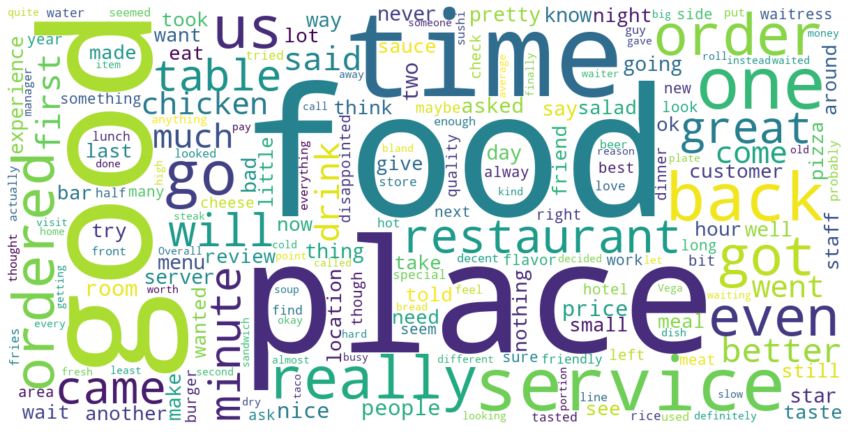

*************************
Rating: 3 stars


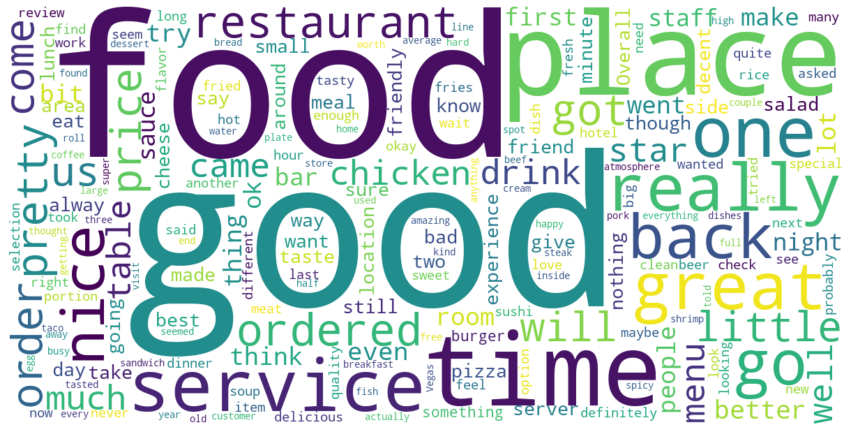

*************************
Rating: 4 stars


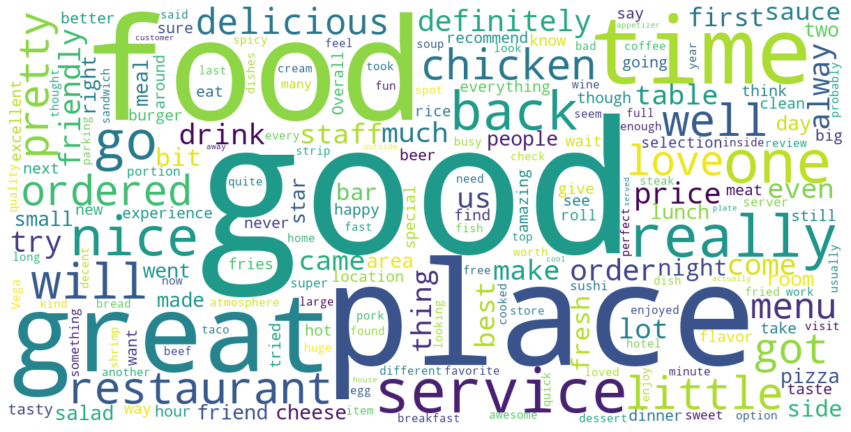

*************************
Rating: 5 stars


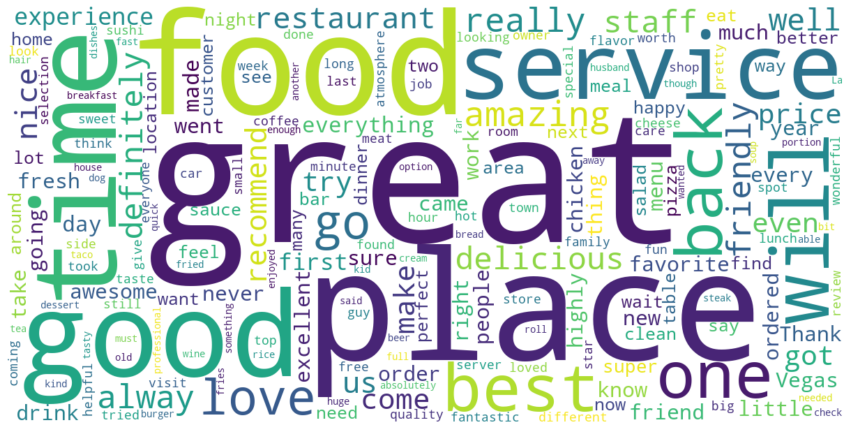

*************************


In [12]:
for rating in sorted(df['stars'].unique()):
    print(f'Rating: {rating} stars')
    
    # Create a single line of text to feed it to WordCloud
    text = ' '.join(review for review in df[df['stars'] == rating]['text'].values)

    # WordCloud uses a built-in stopwords list
    wordcloud = WordCloud(collocations=False, background_color='white', width=1200, height=600).generate(text)

    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    print('*' * 25)

Note significant overlap among the star ratings, as words 'good', 'food', 'service', 'time' and others appear in nearly all categories. This fact alone does not mean much, though. After all, these are just single words (unigrams) and all of them can be modified in a sentence to mean something positive or negative. However, it will most likely be a confusing factor for the bag-of-words model, whereas RNN- and transformer-based models should be able to handle it better.

The reviews will be labeled as positive or negative depending on the number of stars assigned by the users. 4- and 5-star reviews will be considered as positive and 1-, 2-, and 3-star reviews as negative ones.
One possible difficulty for the models might consist in correct interpretation of the corner cases (3- vs 4-star ratings). The classification decision for such reviews might not be obvious. One possible cause is the fact that different people are biased in different ways due to various reasons. In other words, an espresso that I personally enjoy to drink occasionally at a specific café and would rate with 4 stars might not taste good for a professional barista who would rate it with 3 stars.

On the other hand, 1-star rating cloud certainly contains more words with a negative connotation (horrible, problem, left, wrong, issue, etc.) and 5-star rating cloud has mostly words with a positive one (delicious, love, best, friendly, favorite, amazing, awesome, nice, etc). Thus, extreme ratings should not be difficult to recognize and classify.

## Review Length Distribution

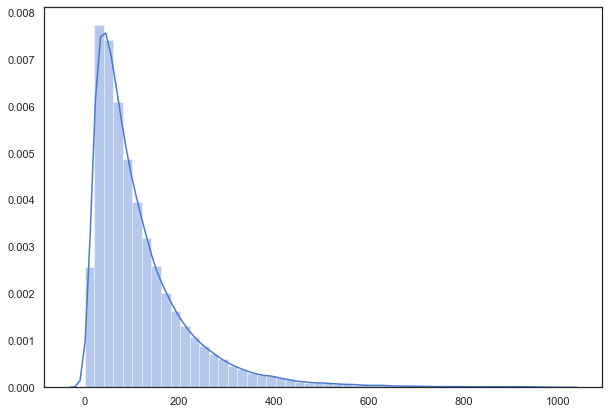

In [13]:
# Review length distribution measured in words
plt.figure(figsize=(10,7))
sns.distplot([len(txt.split()) for txt in df['text'].values])
plt.show()

Overall, most reviews tend to be not too long and do not exceed 300-400 words. The tail of the distribution gets thinner as the number of words increases, which is a rather expected effect. Now, let's see if anything chages for different star ratings.

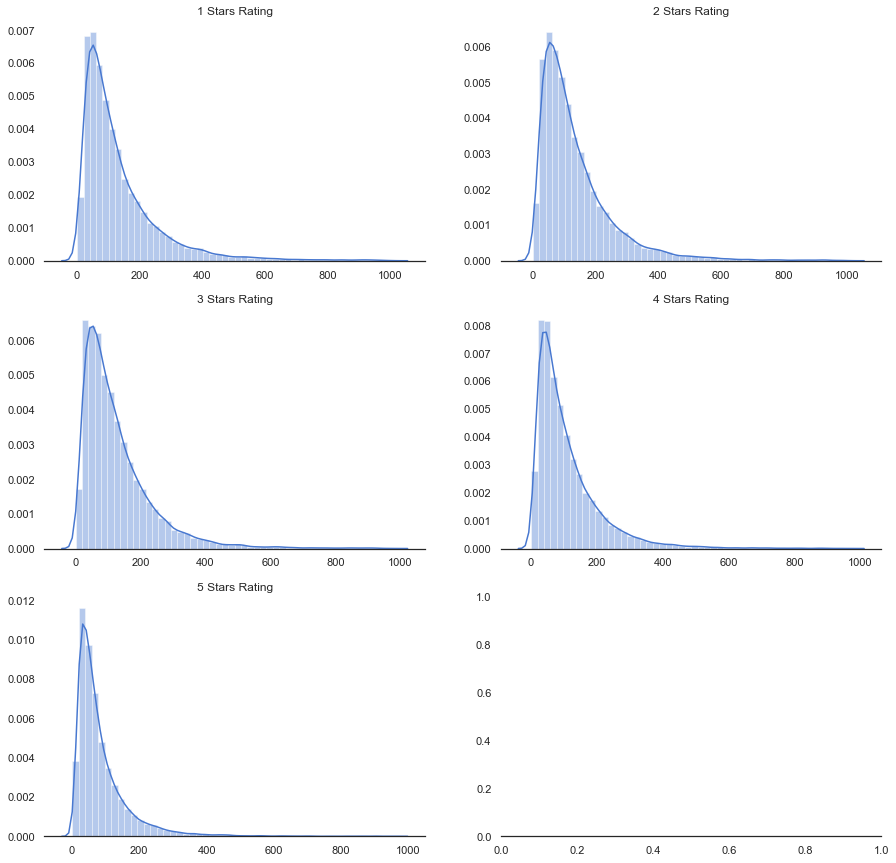

In [14]:
# Set up a plt figure for multiple plots
f, axes = plt.subplots(3, 2, figsize=(15,15), sharex=False)
sns.despine(left=True)

# 
plot_y = 0
for idx, stars in enumerate([1, 2, 3, 4, 5]):
    plot_x = 0 if idx % 2 == 0 else 1
    
    
    sns.distplot(
        [len(txt.split()) for txt in df[df['stars'] == stars]['text'].values], 
        color="b", ax=axes[plot_y, plot_x]).set_title(f'{stars} Stars Rating')
    
    plot_y += 1 if idx % 2 == 1 else 0

The distribution seems to be pretty consistent across all star ratings. The only slight deviation can be pointed out in the 5 stars rating category, where most reviews tend to be even shorter.